In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from kneed import KneeLocator

np.random.seed(42)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Volatility prediction in financial markets 
par CFM (https://challengedata.ens.fr/challenges/22)

Contexte : The American stock market is the most liquid equity market of the planet and hence provides many opportunities for investments. However, when building a stock portfolio by combining financial assets, we need to estimate its future risk, or volatility. The volatility of an asset is loosely defined as the size of the variations of its price over a period of time: a price that doesn't change between the beginning and the end of a period is more volatile if it fluctuates more during the period; a price that changes smoothly has a higher volatility if its overall change is large. There are multiple ways of capturing these two aspects of volatility. The data uses a unique (but secret) definition. Consequently, it is necessary to estimate the future risk of each individual component of the portfolio. The past volatility of a stock is a good proxy of its future risk, but some intraday patterns remain to be found with cutting edge algorithm. And, this is your challenge. CFM specializes in developing quantitative trading strategies and building a portfolio from them. Controlling the risk of our client investments is crucial, thus estimating the future risk of financial assets is the cornerstone of our portfolio construction.

Objectif : Use past volatilities and price changes of financial instruments to predict future volatility and control the risk of financial portfolios

Le code se présente comme suit: 
1. [Qualité des données](#partie1) 
2. [Modélisation](#partie2)


## <a name="partie1"></a>Qualité des données
Après avoir importé nos données, nous allons observer notre dataset et nous attarder sur les 3 points suivants:
1. [Exploration des données](#part11)
2. [Traitement des données manquantes](#part12)
3. [Détection des valeurs aberrantes](#part13)

In [2]:
#todo: on importe nos données
y_train = pd.read_csv(r'./data/y_train.csv', sep=",")
x_train = pd.read_csv(r'./data/x_train.csv', sep=";")
x_test = pd.read_csv(r'./data/x_test.csv', sep=";")

In [3]:
x_train.describe()

,ID,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
count,636313.000000,636313.000000,636313.000000,608222.000000,627558.000000,630656.000000,631557.000000,631777.000000,631501.000000,632508.000000,...,626321.000000,626998.000000,626938.000000,627065.000000,627895.000000,627707.000000,627567.000000,628083.000000,628147.000000,628642.000000
mean,318157.000000,1059.128210,160.248984,0.584382,0.477272,0.408130,0.362365,0.336104,0.308503,0.337733,...,-0.004932,0.022227,0.002102,0.001214,-0.007946,-0.012997,-0.002698,0.001941,-0.008592,-0.008393
std,183687.885257,610.501769,92.014489,0.642999,0.496037,0.437281,0.377806,0.356739,0.323668,0.343424,...,0.908353,0.909381,0.909945,0.909467,0.913197,0.912219,0.912355,0.912933,0.912810,0.914069
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,159079.000000,531.000000,81.000000,0.226861,0.192658,0.164098,0.144090,0.130837,0.120699,0.133030,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,318157.000000,1058.000000,161.000000,0.423908,0.346012,0.294692,0.260319,0.238546,0.220700,0.240355,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,477235.000000,1589.000000,241.000000,0.737118,0.599145,0.511246,0.454621,0.420426,0.388414,0.423885,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,636313.000000,2117.000000,318.000000,46.463028,22.345580,27.829934,18.600202,16.226835,20.255632,11.413828,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a name="part11"></a>Exploration des données
Sommaire des colonnes de notre dataset avec les variables explicatives (X):

    - ID : indexes lines
    - date : randomized dates (2093 days)
    - product_id : identification number of the stock (318 stocks)
    - volatility : volatility over 5-min periods. (a volatility time-stamped by 10:00:00 is the volatility measured between 10:00am and 10:05am)
    - return : sign of the price change during a five-minute period (-1, 0, 1)
    - target : volatility of the same set of stocks and dates measured between 2:00pm and 4:00pm 
   
Sommaire des colonnes de notre dataset avec la variable à expliquer (Y):

    - ID : indexes lines
    - TARGET : volatilité des 2h suivantes

In [4]:
x_train.columns

Index(['ID', 'date', 'product_id', 'volatility 09:30:00',
       'volatility 09:35:00', 'volatility 09:40:00', 'volatility 09:45:00',
       'volatility 09:50:00', 'volatility 09:55:00', 'volatility 10:00:00',
       ...
       'return 13:10:00', 'return 13:15:00', 'return 13:20:00',
       'return 13:25:00', 'return 13:30:00', 'return 13:35:00',
       'return 13:40:00', 'return 13:45:00', 'return 13:50:00',
       'return 13:55:00'],
      dtype='object', length=111)

Nos données de test sont divisées en 3 catégories : les informations sur chaque ligne (ID, date, product_id) , les données de volatilité par tranche de 5 minutes et les données sur les rendements par tranche de 5 minutes. 
On décide donc de diviser en 2 notre dataset pour mieux les analyser. On regarde individuellement : les données relatives à la volatilité et les données relatives aux rendements.

In [5]:
volatility_columns = [col for col in x_train.columns if 'volatility' in col]
return_columns = [col for col in x_train.columns if 'return' in col]

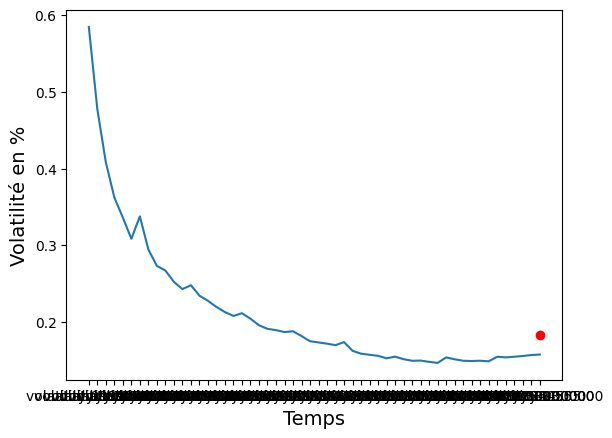

In [6]:
plt.plot(volatility_columns, x_train[volatility_columns].mean())
plt.xlabel("Temps", fontsize=14)
plt.ylabel("Volatilité en %", fontsize=14)
plt.scatter( volatility_columns[-1], y_train['TARGET'].mean(), color='red')

plt.show()

In [7]:
print(f"La volatilité moyenne de tous nos stocks etre 13h55 et 14h00 est de : {x_train[volatility_columns[-1]].mean()}")
print(f"La volatilité moyenne de tous nos stocks entre 14h et 16h est de : {y_train['TARGET'].mean()}")
print(f"La différence entre les deux est de : {y_train['TARGET'].mean() - x_test[volatility_columns[-1]].mean()}")

La volatilité moyenne de tous nos stocks etre 13h55 et 14h00 est de : 0.15778510080891064
La volatilité moyenne de tous nos stocks entre 14h et 16h est de : 0.1835693939280662
La différence entre les deux est de : 0.027521039773085648


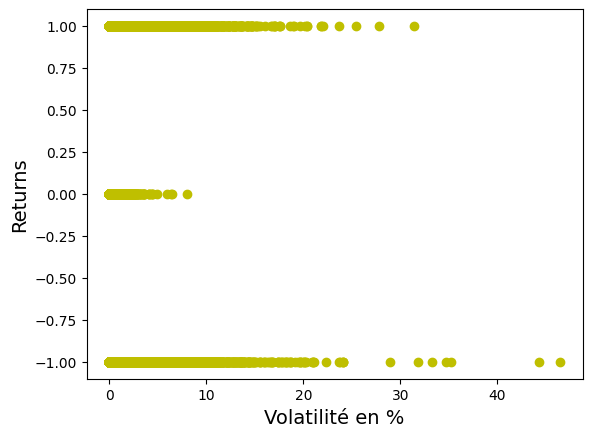

In [8]:
plt.plot(x_train[volatility_columns], x_train[return_columns], "yo")
plt.xlabel("Volatilité en %", fontsize=14)
plt.ylabel("Returns", fontsize=14)

plt.show()

On observe que nos données relatives à la volatilité (moyenne par tranche de 5 minutes) sont décroissantes avec le temps. Notre variable expliquée (Target moyen) est supérieure de 0.0275.
La volatilité est plus importante à l'ouverture des marchés et se calme.
La volatilité moyenne pour chaque stock est relativement faible (autour de 0.2) avec des volatilités plus larges (pics haussiers et baissiers important) pour certains stocks (autour des product_id 200).

 <a name="part12"></a>Traitement des données manquantes

Nous allons identifier les valeurs manquantes et regarder, auquel cas, la méthode d'imputation utilisée.

In [9]:
null_vol = x_train[volatility_columns].isnull().sum()
null_ret = x_train[return_columns].isnull().sum()
print(f"Il existe pour la volitilité {null_vol.sum()} valeurs manquantes")
print(f"Il existe pour les returns {null_ret.sum()} valeurs manquantes")

Il existe pour la volitilité 419817 valeurs manquantes
Il existe pour les returns 419817 valeurs manquantes


On remarque qu'il existe le même nombre de données manquantes pour nos returns et nos volatilités. Regardons si nos tailles de données pour la volatilité et les returns sont de la même taille pour vérifier si les valeurs manquantes sont présentes aux mêmes emplacements. 

In [10]:
print(x_train[volatility_columns].shape, x_train[return_columns].shape)
emplacements_nuls = null_vol & null_ret
print(emplacements_nuls.value_counts())

(636313, 54) (636313, 54)
False    108
Name: count, dtype: int64


C:\Users\ayman\AppData\Local\Temp\ipykernel_12304\2994540404.py:2: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  emplacements_nuls = null_vol & null_ret


Des données manquantes pour nos séries de returns ne sont pas un problème car elles reflètent un changement nul des prix sur une période de 5 minutes.
Des données manquantes pour nos séries de volatilité marquent une période sans transactions (les prix sont alors inchangés) ou une entrée tardive de la transaction dans un système informatique.
Nous interprêtons donc les "NaN" comme des valeurs nulles.
De plus, les valeurs manquantes pour les rendements et les volatilités sont aux mêmes emplacements. Cela confirme notre hypothèse que si le prix de l'actif ne change pas (valeur du return nulle/manquante) alors il a une volatilité nulle/manquant aussi.
Nous avons donc décidé d'interpréter les valeurs manquantes comme des 0. 

In [11]:
x_train= x_train.fillna(0)
x_test = x_test.fillna(0)

<a name="part13"></a> Détection des valeurs aberrantes

Nous allons regarder si il existe des valeurs anormales à l'aide des graphiques précéndents et de la fonction describe.
N'ayant pas d'informations sur le calcul de la volatilité. Nous allons nous baser sur la moyenne.

In [12]:
print(f"Min : {x_train[volatility_columns].min().mean()}")
print(f"Max : {x_train[volatility_columns].max().mean()}")
print(f"Mean : {x_train[volatility_columns].mean().mean()}")
print(f"Std : {x_train[volatility_columns].std().mean()}")

Min : 0.0
Max : 18.47093130083574
Mean : 0.20914620443571086
Std : 0.23906558702351663


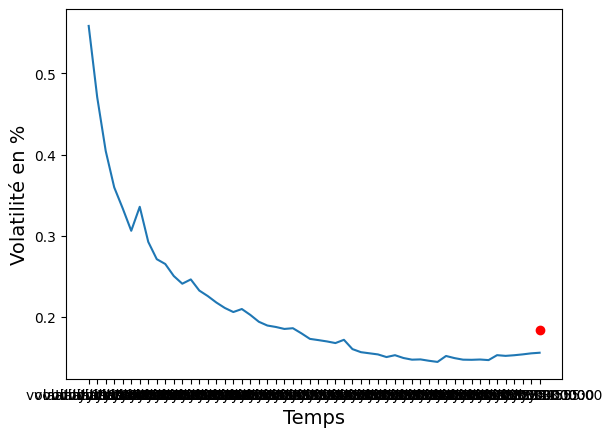

In [13]:
plt.plot(volatility_columns, x_train[volatility_columns].mean())
plt.xlabel("Temps", fontsize=14)
plt.ylabel("Volatilité en %", fontsize=14)
plt.scatter( volatility_columns[-1], y_train['TARGET'].mean(), color='red')

plt.show()

In [14]:
condition = (x_train[return_columns] != 0.0) & (x_train[return_columns] != 1.0) & (x_train[return_columns] != -1.0)
condition.sum().sum()

0

In [15]:
print(f"Min : {x_train[return_columns].min().mean()}")
print(f"Max : {x_train[return_columns].max().mean()}")
print(f"Mean : {x_train[return_columns].mean().mean()}")
print(f"Std : {x_train[return_columns].std().mean()}")

Min : -1.0
Max : 1.0
Mean : -0.001682319049715284
Std : 0.9231860383136582


Les valeurs maximales des volatilités sont très élevées par rapport à la moyenne ce qui incite à croire qu'ils existent de nombres valeurs anormales. Nous avons donc cappé à 12 les volatilités


## <a name="partie1"></a>Modélisation

Nous allons modéliser nos séries pour prédire la volatilité moyenne des 2h qui suivent nos données.
Nos données étant très importante, nous laissons le choix à l'utilisateur de découper ou non le train set selon les stocks. Nous laissons le choix à l'utilisateur de garder un nombre x de stocks et d'entrainer son modèle sur ceux-ci.

Nous réalisons 2 modèles : 
1. [Ridge](#part21) 
2. [PCA](#part22)
3. [K-Means](#part23)
4. [Random Forest](#part24)

In [16]:
keep_y = y_train
keep_x = x_train

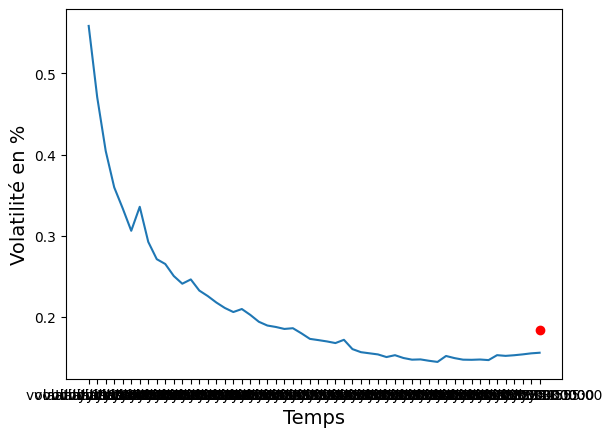

In [17]:
#Si choix d'un sample de notre base de train, possibilité de l'observer à nouveau
plt.plot(volatility_columns, keep_x[volatility_columns].mean())
plt.xlabel("Temps", fontsize=14)
plt.ylabel("Volatilité en %", fontsize=14)
plt.scatter( volatility_columns[-1], y_train['TARGET'].mean(), color='red')

plt.show()

<a name="part21"></a>Régression Ridge

Nous réalisons un modèle de régression simple : la régression Ridge. C’est une régression linéaire avec une contrainte quadratique sur les coefficients. Nos colonnes représentant la même variable décalée dans le temps (intervalle de 5 minutes), on a donc besoin d'un modèle qui ne prend pas chaque variable comme spécifique mais toutes les valeurs dans leur ensemble. Néanmoins, il permet de comprendre les facteurs qui influencent le plus les prédictions du modèle (ici on s'imagine que ce sera une ou plusieurs variations entre 9h30 et 14h).
Nous gardons l'alpha à 1 pour être plus robuste contre l'overfitting.



In [18]:
# Créer et ajuster le modèle Ridge
model_ridge = Ridge(alpha=1.0) 
model_ridge.fit(keep_x[volatility_columns + return_columns], keep_y['TARGET'])

output_ridge_predic = model_ridge.predict(x_test[volatility_columns + return_columns])
output_ridge = pd.DataFrame({'ID': x_test['ID'], 'TARGET': output_ridge_predic})
output_ridge.to_csv(r'./output/output_ridge.csv', index=False)

In [19]:
# Calcul du MAPE entre notre y_train et la prédiction
cv_scores_1 = mean_absolute_percentage_error(y_train['TARGET'], model_ridge.predict(x_train[volatility_columns + return_columns]))
print(f'Le résultat de la MAPE est : {cv_scores_1}')

Le résultat de la MAPE est : 0.26469194224754833


<a name="part22"></a>Principal Component Analysis

Nous réalisons une réduction de dimension avec la méthode de l'Analyse en Composantes Principales (ACP). Cette technique transforme un ensemble de variables corrélées en un ensemble de variables non corrélées, appelées composantes principales, qui sont classées en fonction de la variance qu'elles expliquent. En appliquant l'ACP, nous pouvons réduire la complexité de notre modèle tout en conservant l'essentiel de l'information présente dans les données. Cela est particulièrement utile dans notre cas où nous avons des données avec de nombreuses variables représentant des mesures de volatilité et de rendement. En choisissant un nombre optimal de composantes principales (par exemple, 10), nous pouvons améliorer la performance de nos algorithmes de machine learning et faciliter l'interprétation des résultats.

In [20]:
pca = PCA(n_components=10)  
train_pca = pca.fit_transform(keep_x[volatility_columns + return_columns])
test_pca = pca.fit_transform(x_test[volatility_columns + return_columns])

<a name="part23"></a>K-means

Par la suite nous procédons à définition de cluster par la méthode des K-means. Pour obtenir notre nombre de cluster optimale nos essayons de methode, la première Elbow dans laquelle nous cherchons le point ou un cluster supplémentaire perd en pertinence. La seconde par la méthode de validation croisée disponible dans le module KMeans.
La première méthode nous donne comme résultat 5 et la seconde 10, de plus nous observons que la MAPE de notre Random Forest est inférieur pour 5 (10.931 vs 10.950) nous décidons donc, de poursuivre avec 5 clusters.

In [21]:
#Méthode Elbow
cluster_range = range(2, 11)
inertia_values = []

# Calcule du score d'inertie pour chaque cluster
for n_clusters in cluster_range:
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42) 
    cluster_labels = kmeans.fit_predict(train_pca)
    
    # Sauvegarde du score d'inertie
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(cluster_range, inertia_values, curve='convex', direction='decreasing')
optimal_clusters = kneedle.elbow

print(f'Le nombre de Clusters optimal par method Elbow est : {optimal_clusters}')

Le nombre de Clusters optimal par method Elbow est : 5


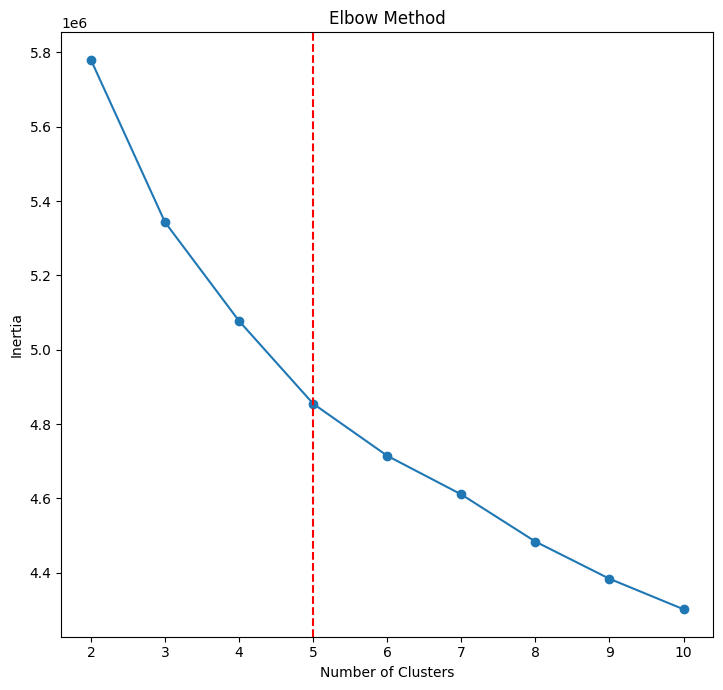

In [22]:
# Plot Elbow Curve
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o')
plt.axvline(x=optimal_clusters, color='r', linestyle='--', label='Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.tight_layout()
plt.show()

In [24]:
#Method Cross Validation
param_grid = {'n_clusters': range(2, 11)} 
kmeans = KMeans(random_state=0)
cross_val = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid)
grid_search.fit(train_pca)
kmeans = KMeans(n_clusters=grid_search.best_estimator_.n_clusters, random_state=42)  
train_clusters = kmeans.fit_predict(train_pca)
test_clusters = kmeans.fit_predict(test_pca)


In [27]:
print(f'Le nombre de Clusters optimal par method Validation croisée est: {grid_search.best_estimator_.n_clusters}')

Le nombre de Clusters optimal par method Validation croisée est: 10


In [28]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)  
train_clusters = kmeans.fit_predict(train_pca)
test_clusters = kmeans.fit_predict(test_pca)

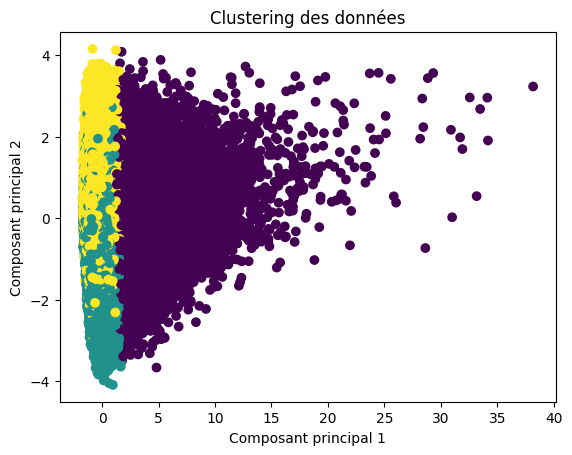

In [ ]:
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_clusters, cmap='viridis')
plt.title('Clustering des données')
plt.xlabel('Composant principal 1')
plt.ylabel('Composant principal 2')
plt.show()

In [ ]:
def extract_features(data, vol_cols, ret_cols):
    features = pd.DataFrame()
    features['vol_mean'] = data[vol_cols].mean(axis=1)
    features['vol_std'] = data[vol_cols].std(axis=1)
    features['vol_min'] = data[vol_cols].min(axis=1)
    features['vol_max'] = data[vol_cols].max(axis=1)
    features['ret_mean'] = data[ret_cols].mean(axis=1)
    features['ret_std'] = data[ret_cols].std(axis=1)
    features['ret_min'] = data[ret_cols].min(axis=1)
    features['ret_max'] = data[ret_cols].max(axis=1)
    return features

train_features = extract_features(keep_x, volatility_columns, return_columns)
test_features = extract_features(x_test, volatility_columns, return_columns)

<a name="part24"></a>Random Forest Regressor

Nous utilisons un modèle de Random Forest Regressor pour prédire notre variable cible. Le Random Forest est une méthode d'assemblage qui combine plusieurs arbres de décision pour améliorer la précision et réduire le risque de surapprentissage. Dans notre implémentation, nous ajoutons les labels de clusters obtenus par K-Means aux caractéristiques d'entraînement et de test, ce qui permet au modèle de tirer parti des segments identifiés dans les données. Nous utilisons 50 arbres (estimators) et fixons la graine aléatoire à 42 pour assurer la reproductibilité des résultats. Après avoir formé le modèle sur les données d'entraînement, nous faisons des prédictions sur les données de test et enregistrons les résultats dans un fichier CSV. L'erreur absolue moyenne en pourcentage (MAPE) entre nos prédictions et les valeurs réelles est calculée pour évaluer la performance du modèle, avec un résultat de 0,109, indiquant une précision acceptable.

In [ ]:
train_features['cluster'] = train_clusters
test_features['cluster'] = test_clusters

rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(train_features, keep_y['TARGET'])

predictions_test_RF = rf.predict(test_features)
output_ranfor = pd.DataFrame({'ID': x_test['ID'], 'TARGET': predictions_test_RF})
output_ranfor.to_csv(r'./output/output_random_forest.csv', index=False)

In [ ]:
# Calcul du MAPE entre notre y_train et la prédiction
predic_train_rf = rf.predict(train_features)
cv_scores = mean_absolute_percentage_error(keep_y['TARGET'], predic_train_rf)
print(f'Le résultat de la MAPE: {cv_scores}')

Le résultat de la MAPE: 0.10931444144559523
